In [1]:
import pandas as pd
import numpy as np
import os

In [93]:
# Directory of Dataset
raw_data_path = "IMU_data"
processed_data_path = "processed_data"

# # Load and preprocess IMU data for each subject and condition
# imu_data = []
# conditions = ['OG_dt_control', 'OG_st_control', 'OG_dt_fatigue', 'OG_st_fatigue']
# for condition in conditions:
#     condition_path = os.path.join('IMU_data', condition)
#     for subject in range(1, 19):
#         if subject not in [4, 16]:  # Missing subjects based on your description
#             subject_id = f'sub_{subject:02d}'
#             subject_path = os.path.join(condition_path, subject_id)
            
#             if os.path.exists(subject_path):
#                 # Call the load_imu_data function to load and preprocess the IMU data
#                 imu_data_subject = load_imu_data(subject_id, condition)
#                 imu_data.append(imu_data_subject)
                
                

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
 
#Load the dataset
def DatasetFromPath(IMU_data_path, processed_data_path):
    
    conditions = ['OG_dt_control', 'OG_st_control', 'OG_dt_fatigue', 'OG_st_fatigue']
    
    Input_IMU = ['LL', 'LF', 'RL', 'RF']
    
    dataset_list = []
    for condition in conditions:
        condition_path_IMU = os.path.join(IMU_data_path, condition)
        condition_path_processed = os.path.join(processed_data_path, condition)
        if (os.path.isdir(condition_path_IMU)) & (os.path.isdir(condition_path_processed)):
            X_list = []
            for subject in os.listdir(condition_path_IMU):
                subject_path_IMU = os.path.join(condition_path_IMU, subject)
                subject_path_processed = os.path.join(condition_path_processed, subject)
                if (os.path.isdir(subject_path_IMU)) & (os.path.isdir(subject_path_processed)):
                    data_list = []
                    for IMU in Input_IMU:
                        data_file_IMU = f'{IMU}.csv'
                        data_file_path_IMU = os.path.join(subject_path_IMU, data_file_IMU)
                        data_file_path_processed = os.path.join(subject_path_processed, 'aggregate_params.csv')
                        if os.path.isfile(data_file_path_IMU):
                            data_IMU = pd.read_csv(data_file_path_IMU, 
                                                   usecols=['GyrX', 
                                                            'GyrY',
                                                            'GyrZ', 
                                                            'AccX',
                                                            'AccY', 
                                                            'AccZ'])
                            data_IMU = data_IMU.add_suffix('_'+IMU)
                            data_list.append(data_IMU)
                        
                        if os.path.isfile(data_file_path_processed):
                            data_speed = pd.read_csv(data_file_path_processed,
                                                     usecols=['speed_avg'])
                            
                    data = pd.concat(data_list, axis=1)
                    data['gait_speed'] = [data_speed.iloc[0, 0]] * len(data)
                    data['subject'] = [int(subject[-2:])] * len(data)
                    X_list.append(data)
            
            X = pd.concat(X_list, axis=0)
            X['condition'] = [condition] * len(X)
            X['condition'] = [condition] * len(X)
            dataset_list.append(X)
    
    Dataset = pd.concat(dataset_list, axis=0)
    
    # Preprocess data
    scaler = StandardScaler()
    Dataset[Dataset.columns.difference(['gait_speed', 'subject', 'condition'])] = scaler.fit_transform(Dataset[Dataset.columns.difference(['gait_speed', 'subject', 'condition'])])

    return Dataset

def segment_data(data, window_size, stride):
    segments = []
    output = []
    
    num_IMU = len([col for col in data.columns if col.startswith('GyrX')])
    
    for condition in data['condition'].unique():
        subset = data[data['condition'] == condition]
        
        for start in range(0, len(subset) - window_size, stride):
            end = start + window_size
            segment = subset.iloc[start:end, :num_IMU*6].values
#             gait_speed = subset.iloc[start:end]['gait_speed'].mean()
            gait_speed = subset.iloc[start:end]['gait_speed']
            
            segments.append(segment)
            output.append(gait_speed)
    
    return np.array(segments), np.array(output)


In [322]:
Dataset = DatasetFromPath(raw_data_path, processed_data_path)

print(Dataset.head())

    GyrX_LL   GyrY_LL   GyrZ_LL   AccX_LL   AccY_LL   AccZ_LL   GyrX_LF   
0  0.027751 -0.088734  0.106713  0.143413  0.192772  0.193143  0.000081  \
1  0.027997 -0.089209  0.107631  0.130653  0.195382  0.182335  0.000389   
2  0.028243 -0.088259  0.106253  0.139153  0.191027  0.185281 -0.000074   
3  0.028490 -0.086357  0.107172  0.130653  0.196246  0.179389  0.000389   
4  0.027012 -0.086832  0.107172  0.130653  0.185790  0.189222  0.000235   

    GyrY_LF   GyrZ_LF   AccX_LF  ...   AccZ_RL   GyrX_RF   GyrY_RF   GyrZ_RF   
0 -0.169108  0.001205  0.226143  ...  0.276084 -0.003266  0.083332 -0.067530  \
1 -0.169108 -0.000403  0.223778  ...  0.283976 -0.003874  0.081870 -0.067530   
2 -0.168606  0.000803  0.221430  ...  0.281006 -0.003418  0.082844 -0.067530   
3 -0.167098  0.001205  0.232443  ...  0.260320 -0.003266  0.081870 -0.067124   
4 -0.169108  0.000401  0.223778  ...  0.272138 -0.003418  0.083819 -0.066718   

    AccX_RF   AccY_RF   AccZ_RF  gait_speed  subject      condition 

In [256]:
window_size = 200
stride = 50
X, y = segment_data(Dataset, window_size, stride)

In [257]:
print(X.shape, y.shape)

(62630, 200, 24) (62630, 200)


In [258]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [259]:

#######################################################################################################################################
# 
# IMU Data :                   timestamp  GyrX    GyrY    GyrZ    AccX    AccY    AccZ
# Preprocessed Data :        stride_lengths_avg    clearances_min_avg       clearances_max_avg
#                            stride_times_avg      swing_times_avg          stance_times_avg
#                            stance_ratios_avg     cadence_avg              speed_avg
#                            stride_lengths_CV     clearances_min_CV        clearances_max_CV
#                            stride_times_CV       swing_times_CV           stance_times_CV
#
# 18-2 = 16 subjects
# Consisting of 6-minute walks under single- (st) and dual-task (dt)
# Conditions in non-fatigued (control) and fatigued (fatigue) states
# 9 units on head (HE), chest(ST), lower back(SA), wrists(LW, RW), legs(LL, RL), and feet(LF, RF)
#######################################################################################################################################

# Use only Control Data
# Use Legs and Feet Data

from torch.utils.data import Dataset
import torch

class GaitDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]



In [260]:
import torch
from torch.utils.data import DataLoader


# Create data loaders
train_dataset = GaitDataset(X_train, y_train)
test_dataset = GaitDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [261]:
import torch
import torch.nn as nn

class GaitLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.5, bi_directional=False):
        super(GaitLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob,
                           bidirectional = bi_directional)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

In [273]:
# Instantiate the model, loss function, and optimizer
input_size = X_train.shape[2]
hidden_size = 128
num_layers = 3
output_size = 1
dropout_prob = 0.4



In [284]:

model = GaitLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)


In [285]:
import matplotlib.pyplot as plt

train_losses = []

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device).float()
        targets = targets.to(device).float()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch: {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

# Plot train result
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

# Save the model's state_dict(parameter)
torch.save(model.state_dict(), 'LSTMmodel_4IMU.pth')

/Users/hyungseok/anaconda3/envs/estimating_speed/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 200])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/hyungseok/anaconda3/envs/estimating_speed/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([24, 200])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1/10, Training Loss: 0.0252
Epoch: 2/10, Training Loss: 0.0094
Epoch: 3/10, Training Loss: 0.0081
Epoch: 4/10, Training Loss: 0.0052
Epoch: 5/10, Training Loss: 0.0034
Epoch: 6/10, Training Loss: 0.0025
Epoch: 7/10, Training Loss: 0.0020
Epoch: 8/10, Training Loss: 0.0018
Epoch: 9/10, Training Loss: 0.0017
Epoch: 10/10, Training Loss: 0.0016


Test Loss: 0.0013
Test accuracy within 0.1 tolerance: 98.32%


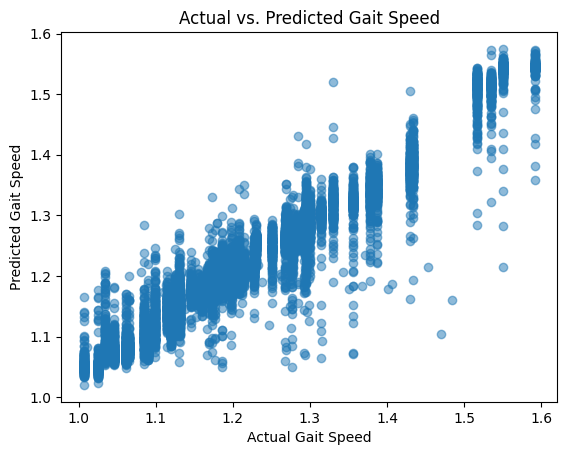

In [318]:
# Initialize the test loss and the total number of correct predictions
test_loss = 0
test_rmse = 0
correct = 0
total = 0
total_samples = 0

actual_speeds = []
predicted_speeds = []

# Iterate through the test dataset
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device).float(), targets.to(device).float()

        # Forward pass
        outputs = model(inputs)
        
        # Calculate the test loss
        loss = criterion(outputs.view(-1), targets.mean(dim=1))
        test_loss += loss.item()
        
        # Compare the predicted gait speed with the average of the actual gait speeds
        total += targets.size(0)
        correct += torch.isclose(outputs.view(-1), targets.mean(dim=1), atol=0.1).sum().item()
        
        # Store the actual and predicted gait speeds
        actual_speeds.extend(targets.mean(axis=1).view(-1).cpu().numpy())
        predicted_speeds.extend(outputs.view(-1).cpu().numpy())

# Calculate the average test loss
test_loss = test_loss / len(test_loader)

# Calculate the accuracy of the model using a custom tolerance
accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}')
print(f'Test accuracy within 0.1 tolerance: {accuracy:.2f}%')

# Create a scatter plot of actual vs. predicted gait speeds
plt.figure()
plt.scatter(actual_speeds, predicted_speeds, alpha=0.5)
plt.xlabel('Actual Gait Speed')
plt.ylabel('Predicted Gait Speed')
plt.title('Actual vs. Predicted Gait Speed')
plt.show()